<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

**Обзор данных**

Начнем исследование с общего обзора данных. Для этого сразу импортируем всё, что необходимо для исследования. 

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

Прочитаем файл. Т.к. проект выполняется локально, а не на платформе, используем конструкцию try-except, чтобы избежать ошибки: 

In [2]:
try:
    data = pd.read_csv('C:/Users/freak/Desktop/Python/ML_BetaBank_project/Churn.csv')

except: 
    data = pd.read_csv('/datasets/Churn.csv')

Ознакомимся с форматом таблицы:

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Обработка пропусков**

Выше можно заметить большое количество пропусков в столбце `Tenure`. Возможно, пропуски возникли из-за того, что клиент заключил договор с банком менее года назад. Т.к. пропуски составляют 9% от общего количества данных, их можно удалить без ущерба для исследования.

In [5]:
data = data.dropna(subset=['Tenure'])

Разумно будет отказаться от заполнения пропусков каким-либо значением, т.к. модель будет использовать его в процессе обучения. Это может исказить результаты исследования.  

**Удаление данных**

Первые три столбца таблицы не содержат важную для исследования информацию. Их можно удалить. 

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

**Обзор дисбаланса целевого признака**

In [7]:
data['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

<AxesSubplot:>

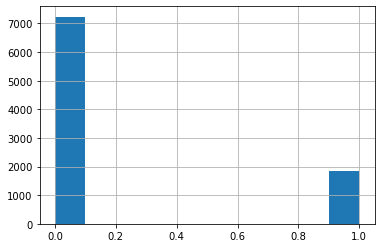

In [8]:
data['Exited'].hist()

Ушедших клиентов в 4 раза меньше, чем оставшихся. Обучим модели без учета дисбаланса, а затем с учетом и сравним показатели. 

**Изменение типов данных**

Заменим типы данных в нескольких столбцах для экономии памяти:

In [9]:
for column in ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Exited']:
    data[column] = data[column].astype('int8')

In [10]:
for column in ['CreditScore', 'Age']:
    data[column] = data[column].astype('float32')

In [11]:
data.info() #посмотрим, удалось ли сэкономить память

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   float32
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   float32
 4   Tenure           9091 non-null   int8   
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int8   
 7   HasCrCard        9091 non-null   int8   
 8   IsActiveMember   9091 non-null   int8   
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int8   
dtypes: float32(2), float64(2), int8(5), object(2)
memory usage: 470.5+ KB


**Масштабирование**

В столбцах `CreditScore`, `Age`, `Balance`, `EstimatedSalary` разный масштаб. Чтобы алгоритм не считал, что один признак важнее другого, масштабируем признаки с помощью `StandardScaler`:

In [12]:
numerics = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
data[numerics] = scaler.fit_transform(data[numerics])

Посмотрим на категориальные признаки: 

<AxesSubplot:>

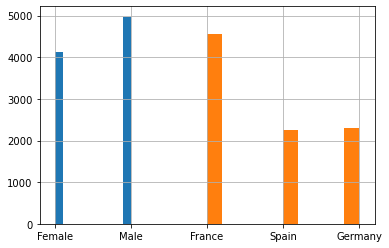

In [13]:
data['Gender'].hist()
data['Geography'].hist()

Количество категорий небольшое — 2 и 3 соответственно. Поэтому можно преобразовать эти признаки методом _One-Hot Encoding_.

In [14]:
data = pd.get_dummies(data, drop_first=True)

Данные готовы к обучению без учета дисбаланса. 

## Исследование задачи

Перед началом обучения выделим признаки и целевой признак:

In [15]:
features = data.drop('Exited', axis=1)
target = data['Exited']

Теперь разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (60% для обучения, по 20% - для тестирования и валидации): 

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=123)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5, random_state=123)

Проверим корректность разделения:

In [17]:
print('Размеры наборов данных:')
print('features_train:', features_train.shape)
print('features_valid:', features_valid.shape)
print('features_test:', features_test.shape)

Размеры наборов данных:
features_train: (5454, 11)
features_valid: (1819, 11)
features_test: (1818, 11)


Данные готовы к обучению различных моделей _без учета дисбаланса_. 

### Решающее дерево

**Без настройки гиперпараметров**

In [18]:
model = DecisionTreeClassifier(random_state=123)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)

In [19]:
accuracy_valid

0.7691039032435404

In [20]:
f1_score(target_valid, predicted_valid)

0.4865525672371638

In [21]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.6735907026449373


F1-мера не дотягивает до указанной в техническом задании. 

**С настройкой глубины**

Проверим работу модели с глубиной деревьев от 1 до 5. 

In [22]:
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions) 
    if result > best_result:
        best_model = model
        best_result = result
        
print("Accuracy лучшей модели:", best_result, best_model)

Accuracy лучшей модели: 0.834524463991204 DecisionTreeClassifier(max_depth=5, random_state=123)


In [23]:
f1_score(target_valid, predictions)

0.4872231686541738

In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8308843173924659


Настройка гиперпараметров решающего дерева практически не повлияла на значение F1-меры. Accuracy и AUC-ROC увеличились после настройки гиперпараметров. 

### Случайный лес

**Без настройки гиперпараметров**

In [25]:
model = RandomForestClassifier(random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = model.score(features_valid, target_valid)
print(accuracy)

0.8372732270478285


In [26]:
f1_score(target_valid, predicted_valid)

0.5316455696202532

In [27]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.826636387924125


У модели случайного леса без настройки гиперпараметров F1-мера близка к необходимому значению 0.59.

**С настройкой гиперпараметров**

Попробуем подобрать гиперпараметры с помощью GridSearchCV:

`n_estimators` — количество деревьев

`max_depth` — максимальная глубина древа

`min_samples_leaf` — минимальное количество объектов в листе

`min_samples_split` — минимальное количество объектов в узле

In [28]:
clf = RandomForestClassifier(random_state=123)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [29]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 40}

Теперь используем полученные гиперпараметры для алгоритма случайного леса: 

In [30]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = model.score(features_valid, target_valid)
print(accuracy)

0.8438702583837273


In [31]:
f1_score(target_valid, predicted_valid)

0.5328947368421052

In [32]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8416029922522041


Снова F1-мера не дотягивает до необходимого значения 0.59. Accuracy и AUC-ROC, как и в случае с решающим деревом, увеличились после настройки гиперпараметров.

### Логистическая регрессия

In [33]:
model = LogisticRegression(random_state=123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy = model.score(features_valid, target_valid)
print(accuracy)

0.80043980208906


In [34]:
f1_score(target_valid, predicted_valid)

0.324022346368715

In [35]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7378965179446078


Логистическая регрессия показывает самый низкий результат F1-меры: 0.32

**Выводы:**

- Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (60% для обучения, по 20% - для тестирования и валидации);
- Обучение моделей Решающего дерева, Случайного леса и Логистической регресии без учета дисбаланса не позволило достигнуть необходимых значений F1-меры; 
- Максимальное значение F1-меры — 0.53 было достигнуто при обучении модели Случайного леса.

## Борьба с дисбалансом

В начале нашего исследования мы выяснили, что оставшихся клиентов в 4 раза больше, чем ушедших. Соотношение классов 4:1.

Для борьбы с дисбалансом попробуем следующее: 

- взвешивание классов;

- увеличение выборки положительного класса;

- уменьшение выборки отрицательного класса.

### Взвешивание классов

Начнем взвешивание с самой перспективной модели — Случайный лес с настроенными гиперпараметрами. 

In [36]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, 
                               random_state=123, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.5990220048899756
AUC-ROC: 0.8472758037225043


F1 соответствует техническому заданию. 

Посмотрим, что даст взвешивание на моделях Решающего дерева и Логистической регрессии: 

In [37]:
model = DecisionTreeClassifier(max_depth=5, random_state=123, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.5597210113339145
AUC-ROC: 0.8295369133493633


In [38]:
model = LogisticRegression(random_state=123, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.47830101569713757
AUC-ROC: 0.7427268679312494


Можно заметить, что в обоих случаях F1-мера заметно увеличилась. Однако, этого недостаточно. 

Самый высокий результат снова показывает Случайный лес. 

### Увеличение выборки

Объявим 4 переменные и запишем в них признаки с ответом 0 и 1, а также целевой признак с ответом только 0 и только 1:

In [39]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target == 0]
target_ones = target_train[target == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4343, 11)
(1111, 11)
(4343,)
(1111,)


Создадим функцию `upsample()` с тремя параметрами:

`features` — признаки,

`target` — целевой признак,

`repeat` — количество повторений.

Функция вернёт признаки и целевой признак после операции upsampling.

In [40]:
def upsample(features, target, repeat):
    
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
   
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    return features_upsampled, target_upsampled 
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)


(8787, 11)
(8787,)


Обучим модель Случайного леса на новых данных. Начинаем именно с этой модели, т.к. ранее она показала самые хорошие результаты:

In [41]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, 
                               random_state=123)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_upsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_upsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.6061269146608316
AUC-ROC: 0.9530744923444681


Посмотрим, как повлияло увиличение выборки на Решающее дерево и Логистическую регрессию: 

In [42]:
model = LogisticRegression(random_state=123, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_upsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_upsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.48043676069153785
AUC-ROC: 0.7757781073985823


In [43]:
model = DecisionTreeClassifier(max_depth=5, random_state=123)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_upsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_upsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.5597210113339145
AUC-ROC: 0.8446753033581047


Увеличение выборки помогло достичь желаемых результатов для модели Случайного леса с заданными гиперпараметрами, но не помогло увеличить F1-меру у Решающего дерева и Логистической регрессии.

### Уменьшение выборки 

Создадим функцию `downsample()` с тремя аргументами:
    
`features` — признаки;

`target` — целевой признак;

`fraction` — доля отрицательных объектов, которые нужно сохранить.


In [44]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1980, 11)
(1980,)


In [45]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, 
                               random_state=123)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_downsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_downsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.548780487804878
AUC-ROC: 0.9630590216674141


In [46]:
model = DecisionTreeClassifier(max_depth=5, random_state=123)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_downsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_downsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.5659340659340659
AUC-ROC: 0.8571026838011764


In [47]:
model = LogisticRegression(random_state=123, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_downsampled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_downsampled, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.48314606741573035
AUC-ROC: 0.7802205997354626


Уменьшение выборки не помогло достичь нужного значения F1-меры ни для одной из моделей. Ближе всех к необходимому значению оказалось решающее дерево. 

## Тестирование модели

Проведем тестирование на Случайном лесе. Именно эта модель два раза продемонстрировала соответствие F1-меры техническому заданию. 

В первом случае протестируем Случайный лес с настроенными гиперпараметрами и взвешенными классами. 

In [48]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, 
                               random_state=123, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.6338797814207651
AUC-ROC: 0.8798044007872343


Во втором случае ротестируем Случайный лес с настроенными гиперпараметрами и увеличенной выборкой.

In [49]:
model = RandomForestClassifier(n_estimators=50, max_depth=9, min_samples_leaf=1, min_samples_split=6, 
                               random_state=123)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print('AUC-ROC:', auc_roc)

F1: 0.6273525721455459
AUC-ROC: 0.8729794940713621


## Вывод

Лучшая модель имеет следующие характеристики: 

- RandomForestClassifier
    
- n_estimators=40, max_depth=9, min_samples_leaf=1, min_samples_split=6
    
- устранение дисбаланса целевого признака путем взвешивания классов: class_weight='balanced'
        
Лучшие значения метрик для такой модели: 

F1: 0.63
    
AUC-ROC: 0.87